# Configure Dataset Paths

In [1]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5
IN_LAST_LAYER = 10
SEED = 1337

train_dir = "C:/data/New Plant Diseases Dataset/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "C:/data/New Plant Diseases Dataset/New Plant Diseases Dataset(Augmented)/valid"


print("train_dir:",train_dir)
print("valid_dir:",valid_dir)

train_dir: C:/data/New Plant Diseases Dataset/New Plant Diseases Dataset(Augmented)/train
valid_dir: C:/data/New Plant Diseases Dataset/New Plant Diseases Dataset(Augmented)/valid


In [2]:
import os
import random
import matplotlib.pyplot as plt


def show_sample_images(base_path, num_classes=5, images_per_class=3):
    """Display random sample images from dataset"""

    # get only folders (classes)
    class_names = [d for d in os.listdir(base_path)
                   if os.path.isdir(os.path.join(base_path, d))]

    if len(class_names) == 0:
        print("No class folders found!")
        return

    random_classes = random.sample(class_names, min(num_classes, len(class_names)))

    fig, axes = plt.subplots(len(random_classes), images_per_class,
                             figsize=(12, 3*len(random_classes)))
    fig.suptitle('Sample Images from Dataset', fontsize=16)

    # handle subplot shape edge cases
    if len(random_classes) == 1:
        axes = [axes]
    if images_per_class == 1:
        axes = [[ax] for ax in axes]

    valid_ext = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    for i, class_name in enumerate(random_classes):
        class_path = os.path.join(base_path, class_name)

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(valid_ext)]

        if len(images) == 0:
            print(f"Skipping empty class: {class_name}")
            continue

        random_images = random.sample(images, min(images_per_class, len(images)))

        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_path, img_name)

            try:
                img = plt.imread(img_path)
                axes[i][j].imshow(img)
                axes[i][j].axis('off')

                if j == 0:
                    axes[i][j].set_title(class_name.replace('_', '\n'), fontsize=10)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.show()

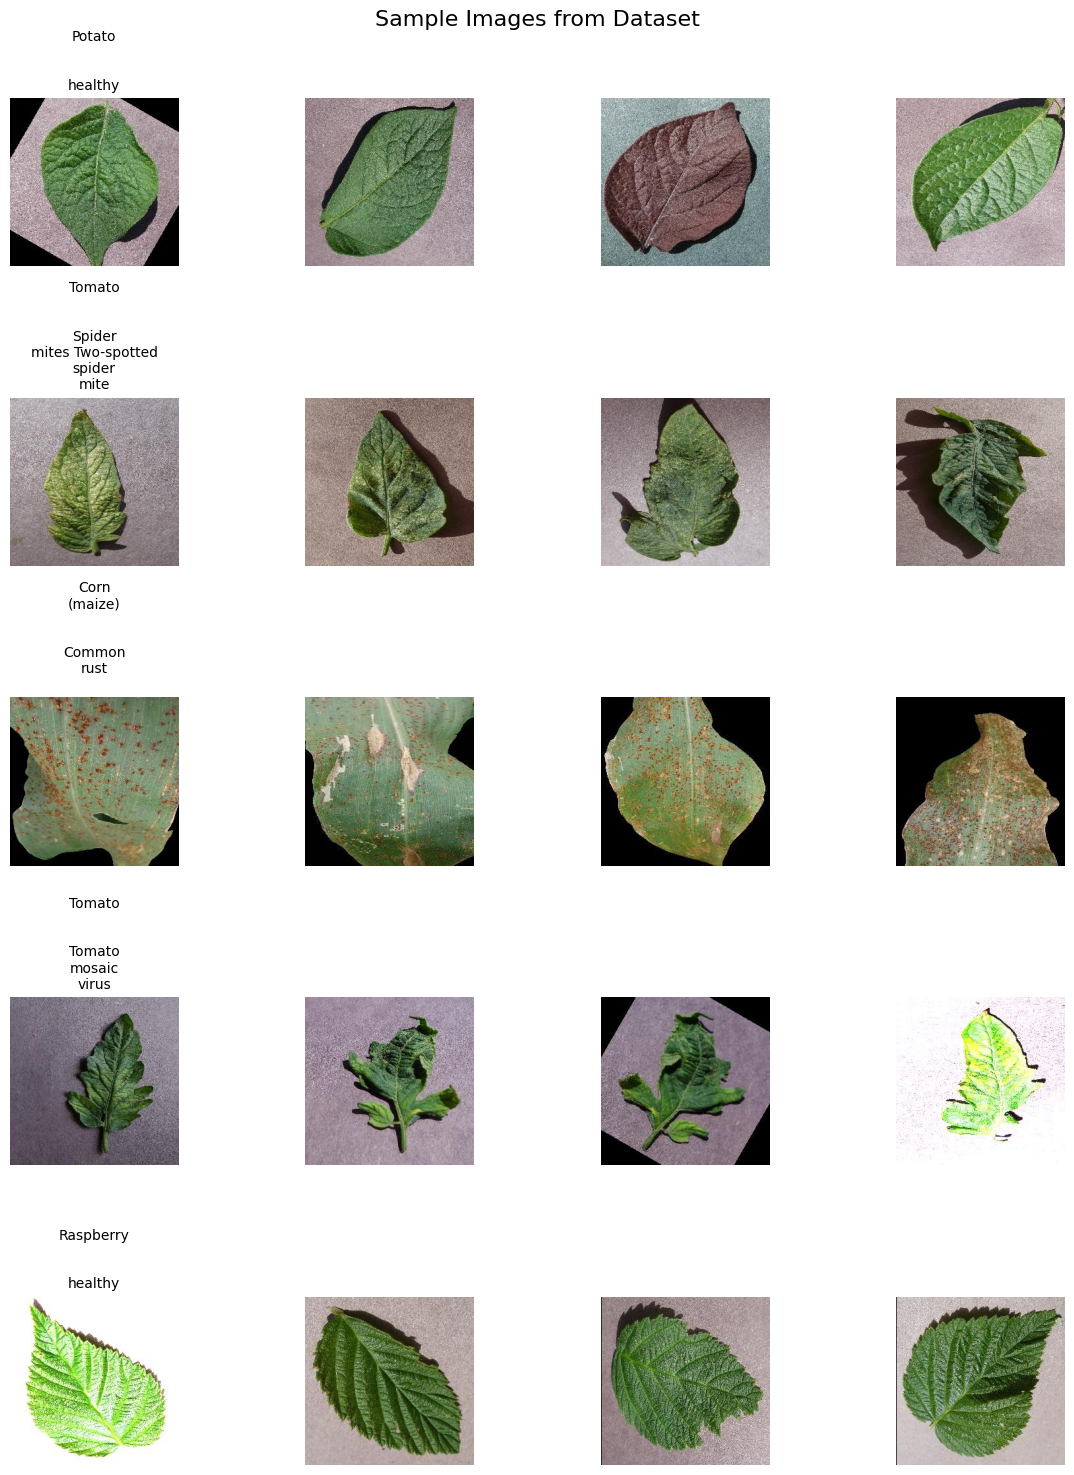

In [3]:
show_sample_images(train_dir, num_classes=5, images_per_class=4)

In [4]:
import os

VALID_EXT = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp')


def count_images(directory):
    """Count total images and per-class images (safe & accurate)"""

    total_images = 0
    class_counts = {}

    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return 0, {}

    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)

        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(VALID_EXT)]

        num_images = len(images)

        if num_images == 0:
            print(f"⚠️ Empty class skipped: {class_name}")
            continue

        class_counts[class_name] = num_images
        total_images += num_images

    return total_images, class_counts

In [5]:
train_total, train_counts = count_images(train_dir)
valid_total, valid_counts = count_images(valid_dir)

print(f"Training images: {train_total}")
print(f"Validation images: {valid_total}")
print(f"Number of classes: {len(train_counts)}")

print("\nClass distribution (first 10):")
for i, (class_name, count) in enumerate(list(train_counts.items())[:10]):
    print(f"  {class_name}: {count} images")

Training images: 70295
Validation images: 17572
Number of classes: 38

Class distribution (first 10):
  Apple___Apple_scab: 2016 images
  Apple___Black_rot: 1987 images
  Apple___Cedar_apple_rust: 1760 images
  Apple___healthy: 2008 images
  Blueberry___healthy: 1816 images
  Cherry_(including_sour)___Powdery_mildew: 1683 images
  Cherry_(including_sour)___healthy: 1826 images
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
  Corn_(maize)___Common_rust_: 1907 images
  Corn_(maize)___Northern_Leaf_Blight: 1908 images


In [6]:
largest = max(train_counts.values())
smallest = min(train_counts.values())

print("\nDataset imbalance ratio:", round(largest/smallest,2), "x")


Dataset imbalance ratio: 1.23 x


# Data Preprocessing

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with light augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='reflect'
)

# Validation data generator (no augmentation)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


# Model Building and Training

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
from tensorflow.keras.applications import MobileNetV2

# image size you used in generator
IMG_SIZE = (224, 224)

# number of classes (from generator)
NUM_CLASSES = train_gen.num_classes

# how many layers to unfreeze
N_LAST_LAYERS = 10

# Load pretrained backbone
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

print("Backbone loaded:", base_model.name)

Backbone loaded: mobilenetv2_1.00_224


In [10]:
# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last N layers for fine-tuning
if N_LAST_LAYERS > 0:
    for layer in base_model.layers[-N_LAST_LAYERS:]:
        layer.trainable = True

# Count trainable parameters
trainable_count = sum([tf.size(w).numpy() for w in base_model.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in base_model.non_trainable_weights])

print(f"Trainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")
print(f"Unfrozen last {N_LAST_LAYERS} layers for fine-tuning")

Trainable parameters: 732,480
Non-trainable parameters: 1,525,504
Unfrozen last 10 layers for fine-tuning


### What is Transfer Learning? 
Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second task. It's a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks.

Why MobileNetV2?

MobileNetV2 is specifically designed for mobile and embedded vision applications.It features:

● Efficient Architecture: Uses depthwise separable convolutions

● Inverted Residuals: Linear bottleneck layers

● Lightweight: Fewer parameters compared to other architectures

● High Accuracy: Maintains competitive accuracy despite smaller size

● Pre-trained Weights: Trained on ImageNet with 1000 classes

In [11]:
# Build the complete model
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)  # Frozen BatchNorm layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="mobilenetv2_plant_disease_classifier")

# Display model summary
model.summary()

Model: "mobilenetv2_plant_disease_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (

Architecture Explanation:

Input Layer: Accepts 224x224x3 RGB images

MobileNetV2 Base: Pre-trained feature extractor (partially frozen)

GlobalAveragePooling2D: Reduces spatial dimensions to 1D

Dropout (0.35): Regularization to prevent overfitting

Dense (256): Fully connected layer with ReLU activation

Dropout (0.25): Additional regularization

Output Dense (38): Final classification layer with softmax

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compilation Settings Explanation

● Optimizer: Adam with learning rate 1e-4 (low rate prevents disrupting pre-trained weights)

● Loss Function: Categorical crossentropy (standard for multi-class classification)

● Metrics: Accuracy for monitoring training progress



In [13]:
model.summary()

Model: "mobilenetv2_plant_disease_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (

In [14]:
# Define training callbacks
callbacks = [
    # Save best model based on validation accuracy
    keras.callbacks.ModelCheckpoint(
        "corn_mobilenetv2_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),

    # Stop training if no improvement
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

print("Callbacks configured:")
print(" 1. ModelCheckpoint - Saves best model")
print(" 2. ReduceLROnPlateau - Adjusts learning rate")
print(" 3. EarlyStopping - Prevents overfitting")

Callbacks configured:
 1. ModelCheckpoint - Saves best model
 2. ReduceLROnPlateau - Adjusts learning rate
 3. EarlyStopping - Prevents overfitting


Callbacks Explanation:

ModelCheckpoint: Automatically saves the model with the best validation accuracy

ReduceLROnPlateau: Reduces learning rate by 50% if validation loss doesn't improve for 3 epochs

EarlyStopping: Stops training if validation loss doesn't improve for 6 epochs

In [15]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10
)

Epoch 1/10
2197/2197 [==============================] - 570s 257ms/step - loss: 0.7021 - accuracy: 0.7901 - val_loss: 0.2287 - val_accuracy: 0.9252
Epoch 2/10
2197/2197 [==============================] - 722s 329ms/step - loss: 0.2502 - accuracy: 0.9171 - val_loss: 0.1788 - val_accuracy: 0.9393
Epoch 3/10
2197/2197 [==============================] - 720s 328ms/step - loss: 0.1899 - accuracy: 0.9370 - val_loss: 0.1382 - val_accuracy: 0.9537
Epoch 4/10
2197/2197 [==============================] - 814s 370ms/step - loss: 0.1576 - accuracy: 0.9473 - val_loss: 0.1075 - val_accuracy: 0.9635
Epoch 5/10
2197/2197 [==============================] - 819s 373ms/step - loss: 0.1355 - accuracy: 0.9543 - val_loss: 0.1106 - val_accuracy: 0.9632
Epoch 6/10
2197/2197 [==============================] - 680s 309ms/step - loss: 0.1212 - accuracy: 0.9595 - val_loss: 0.1407 - val_accuracy: 0.9536
Epoch 7/10
2197/2197 [==============================] - 873s 397ms/step - loss: 0.1090 - accuracy: 0.9637 - val_

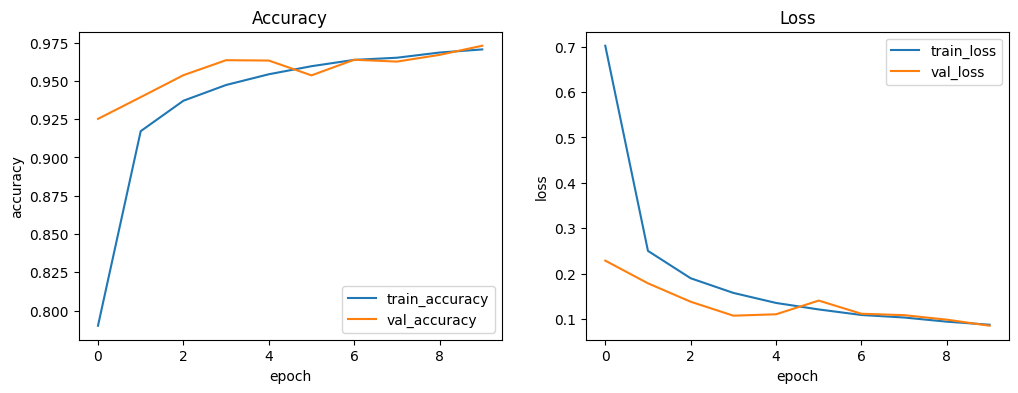

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy',[]), label='train_accuracy')
plt.plot(history.history.get('val_accuracy',[]), label='val_accuracy')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history.get('loss',[]), label='train_loss')
plt.plot(history.history.get('val_loss',[]), label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss')

plt.show()

Training Analysis: The training curves show:

● Rapid initial learning: Training accuracy jumps from 79.01% to 91.71% in the first epoch

● Steady improvement: Validation accuracy improves from 92.52% to 96.32% over 5 epochs

● No overfitting: Training and validation curves remain close, indicating good generalization

● Convergence: Both loss curves decrease smoothly, showing stable training


# Testing

In [34]:
test_dir = "C:/data/New Plant Diseases Dataset/test"

In [35]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False 
)

Found 33 images belonging to 1 classes.


In [36]:
print("TRAIN:", train_gen.class_indices)
print("TEST :", test_gen.class_indices)

TRAIN: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 

In [37]:
pred_probs = model.predict(test_gen)
pred_classes = pred_probs.argmax(axis=1)

33/33 [==============================] - 2s 17ms/step


In [38]:
class_names = list(train_gen.class_indices.keys())

for img, idx in zip(test_gen.filenames, pred_classes):
    print(img, "→", class_names[idx])

test\AppleCedarRust1.JPG → Apple___Cedar_apple_rust
test\AppleCedarRust2.JPG → Apple___Cedar_apple_rust
test\AppleCedarRust3.JPG → Apple___Cedar_apple_rust
test\AppleCedarRust4.JPG → Apple___Cedar_apple_rust
test\AppleScab1.JPG → Apple___Apple_scab
test\AppleScab2.JPG → Apple___Apple_scab
test\AppleScab3.JPG → Squash___Powdery_mildew
test\CornCommonRust1.JPG → Corn_(maize)___Common_rust_
test\CornCommonRust2.JPG → Corn_(maize)___Common_rust_
test\CornCommonRust3.JPG → Corn_(maize)___Common_rust_
test\PotatoEarlyBlight1.JPG → Potato___Early_blight
test\PotatoEarlyBlight2.JPG → Potato___Early_blight
test\PotatoEarlyBlight3.JPG → Potato___Early_blight
test\PotatoEarlyBlight4.JPG → Potato___Early_blight
test\PotatoEarlyBlight5.JPG → Potato___Early_blight
test\PotatoHealthy1.JPG → Potato___healthy
test\PotatoHealthy2.JPG → Potato___healthy
test\TomatoEarlyBlight1.JPG → Tomato___Early_blight
test\TomatoEarlyBlight2.JPG → Tomato___Early_blight
test\TomatoEarlyBlight3.JPG → Tomato___Early_blig

# Evaluation

In [39]:
eval_dir = "C:/data/New Plant Diseases Dataset/evaluate"

In [41]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

class_names = list(train_gen.class_indices.keys())

eval_gen = eval_datagen.flow_from_directory(
    eval_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=class_names,
    class_mode='categorical',
    shuffle=False
)

loss, acc = model.evaluate(eval_gen)
print("Test Accuracy:", acc)

Found 29 images belonging to 38 classes.


1/1 [==============================] - 0s 469ms/step - loss: 0.0987 - accuracy: 0.9655
Test Accuracy: 0.9655172228813171


In [44]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# predict
pred = model.predict(eval_gen)
pred_classes = np.argmax(pred, axis=1)

# ground truth
true_classes = eval_gen.classes

# IMPORTANT: use training labels (38 diseases)
class_labels = list(train_gen.class_indices.keys())

print(classification_report(true_classes, pred_classes, labels=range(len(class_labels)), target_names=class_labels))

1/1 [==============================] - 0s 104ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.67      0.80         3
                                 Apple___Black_rot       0.00      0.00      0.00         0
                          Apple___Cedar_apple_rust       1.00      1.00      1.00         4
                                   Apple___healthy       0.00      0.00      0.00         0
                               Blueberry___healthy       0.00      0.00      0.00         0
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         0
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00         0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         0
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00         3
               Corn_(maize

c:\Users\ASUS\.conda\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\.conda\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\.conda\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\.conda\envs\tf_gpu\lib\si

In [46]:
cm = confusion_matrix(true_classes, pred_classes, labels=range(len(class_labels)))
print(cm.shape)   

(38, 38)


# Save Model

In [49]:
model.save("plant_disease_model")

INFO:tensorflow:Assets written to: plant_disease_model\assets


INFO:tensorflow:Assets written to: plant_disease_model\assets


In [50]:
model.save("plant_disease_model.keras")
model.save("plant_disease_model.h5")